In [3]:
%pylab inline
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [4]:
path='/home/jfm343/Documents/Moire_phonon/BM_bandstructure/Mods/data20_mode_L_symmetry_a_alpha_0.0_beta_1.0_umklp_0_kappa_0.8174358974358973_theta_0.01832595714594046.h5'
df = pd.read_hdf(path)

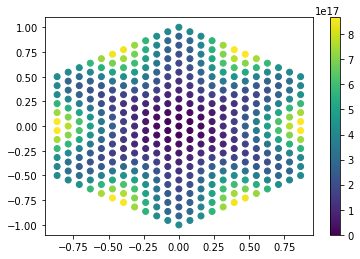

In [5]:
df_prime=df.loc[df['nu']==0]
scatter(df_prime['kx'],df_prime['ky'], c=df_prime['bub'])
colorbar()

Text(0, 0.5, '$\\alpha/ c_L$')

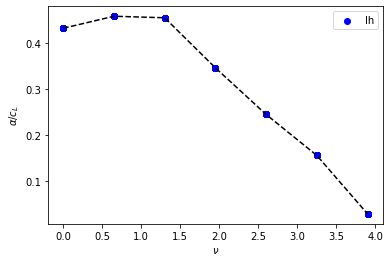

In [6]:

fillings=df['nu']
cep=df['delt_cph']/21400
plt.scatter(fillings, cep, c='b', label='lh')
plt.plot(fillings, cep, c='k', ls='--')
plt.legend()
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\alpha/ c_L$")
# plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


## For the twist angle

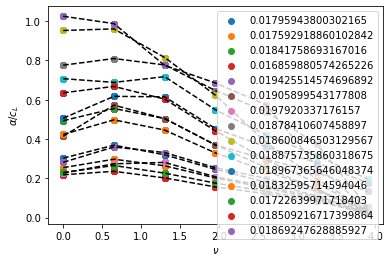

In [7]:
path='/home/jfm343/Documents/Moire_phonon/BM_bandstructure/data/thetasweep_kappa_0.817_beta_4ev_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
for i, pat in enumerate(subpaths):
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'T')
    fullpath=fulpath+'/'+data[0]
    
    df = pd.read_hdf(fullpath)
    
    fillings=df['nu']
    cep=df['delt_cph']/21400
    cep2=np.sqrt(np.abs(1-cep**2))
    plt.scatter(fillings, cep, label=str(df['theta'][0]))
    plt.plot(fillings, cep, c='k', ls='--')
    plt.legend()
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\alpha/ c_L$")
    thet.append(df['theta'][0].flatten())
    renorm.append(cep[0])
    renorm2.append(cep2[0])
    # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")

    


range of twist angles 0.010499999999999954
0.95
0.955
0.96
0.965
0.97
0.975
0.98
0.985
0.99
0.995
1.0
1.005
1.01
1.015
1.02
1.025
1.03
1.035
1.04
1.045


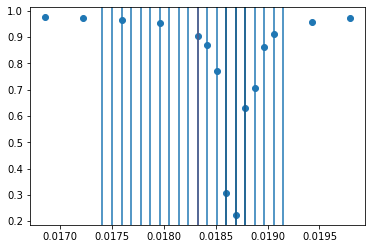

In [8]:
scatter(thet, renorm2)
axvline(1.05*np.pi/180, c='r')
axvline((1.015)*1.05*np.pi/180, c='k')
axvline((1.025)*1.05*np.pi/180, c='k')
axvline((1.02)*1.05*np.pi/180, c='k')
print("range of twist angles", (1.025)*1.05-(1.015)*1.05)
NS=20
for i in range(NS):
    l=(i-int(NS/2))*0.005
    axvline((1+l)*1.05*np.pi/180)
    print((1+l))

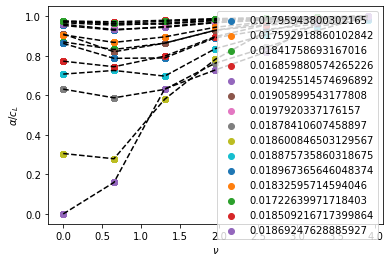

In [9]:
path='/home/jfm343/Documents/Moire_phonon/BM_bandstructure/data/thetasweep_kappa_0.817_beta_4ev_N30'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        

for i, pat in enumerate(subpaths):
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'T')
    fullpath=fulpath+'/'+data[0]
    
    df = pd.read_hdf(fullpath)
    
    fillings=df['nu']
    cep=df['delt_cph']/21400
    cep2=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)
    plt.scatter(fillings, cep2, label=str(df['theta'][0]))
    plt.plot(fillings, cep2, c='k', ls='--')
    plt.legend()
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\alpha/ c_L$")
    # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


# For kappa

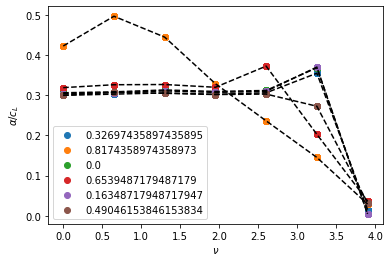

In [10]:
path='/home/jfm343/Documents/Moire_phonon/BM_bandstructure/data/kappasweep_theta_1.05_beta_4ev_N30_2022-01-20-09-58-20'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        

for i, pat in enumerate(subpaths):
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'T')
    fullpath=fulpath+'/'+data[0]
    
    df = pd.read_hdf(fullpath)
    
    fillings=df['nu']
    cep=df['delt_cph']/21400
    cep2=np.sqrt(1-cep**2)
    plt.scatter(fillings, cep, label=str(df['kappa'][0]))
    plt.plot(fillings, cep, c='k', ls='--')
    plt.legend()
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\alpha/ c_L$")
    # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


In [19]:
import Hamiltonian
import MoireLattice
from scipy import linalg as la

#Lattice parameters 
#lattices with different normalizations
modulation_thet=1
Nsamp=10
theta=modulation_thet*1.05*np.pi/180  # magic angle 
l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
[KX,KY]=lq.Generate_lattice()
Npoi=np.size(KX); print(Npoi, "numer of sampling lattice points")
[q1,q2,q3]=l.q
q=la.norm(q1)
umkl=0
print(f"taking {umkl} umklapps")
VV=lq.boundary()

print(q, 2*np.sin(theta/2)*np.pi*(4/3))

starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.005800485610961914  s
91 numer of sampling lattice points
taking 0 umklapps
0.07676251561000431 0.0767625156100043
